# Analysis for Summers, 2020

In [1]:
%%capture 
# Hide matplotlib backend error

import os
import pandas as pd 
from sklearn import preprocessing
from math import sqrt
from statistics import mean, stdev
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
import GEOparse
import xpressplot as xp

sns.set(font='arial')
_jakes_cmap = sns.diverging_palette(212, 61, s=99, l=77, sep=1, n=16, center='dark') #Custom aesthetics

%matplotlib inline

#Set path to this directory for accessing and saving files
__path__  = os.getcwd() + os.path.sep

In [2]:
print(__path__)

/home/jordan/Desktop/projects/summers_2020/


In [3]:
test_genes = [
    'SPTLC1',
    'SPTLC2',
    'CERS6',
    'DEGS1',
    'DEGS2',
    'SGMS1',
    'SGMS2'
]

In [4]:
"""Cohen's d effect size scale:
Very small   0.01
Small        0.20
Medium       0.50
Large        0.80
Very large   1.20
Huge         2.0

Source:
- Cohen, Jacob (1988). Statistical Power Analysis for the Behavioral Sciences. 
    Routledge. ISBN 978-1-134-74270-7.
- Sawilowsky, S (2009). "New effect size rules of thumb". 
    Journal of Modern Applied Statistical Methods. 8 (2): 467–474. 
    doi:10.22237/jmasm/1257035100.
"""

def eval_cohens(comp, base):
    
    def cohen_d(comp, base):
        return (mean(comp) - mean(base)) / (sqrt((stdev(comp) ** 2 + stdev(base) ** 2) / 2))
    
    e = cohen_d(comp, base)
    status = ""
    if abs(e) < 0.01:
        status = "Negligible"
    elif abs(e) >= 0.01 and abs(e) < 0.2:
        status = "Very small"
    elif abs(e) >= 0.2 and abs(e) < 0.5:
        status = "Small"
    elif abs(e) >= 0.5 and abs(e) < 0.8:
        status = "Medium"
    elif abs(e) >= 0.8 and abs(e) < 1.2:
        status = "Large"
    elif abs(e) >= 1.2 and abs(e) < 2.0:
        status = "Very large"
    else:
        status = "Huge"
    print(gene + ":\t" + str(round(e, 2)) + "\t(" + status + ")")

# GEO Microarray data

### Read data for GSE8671

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


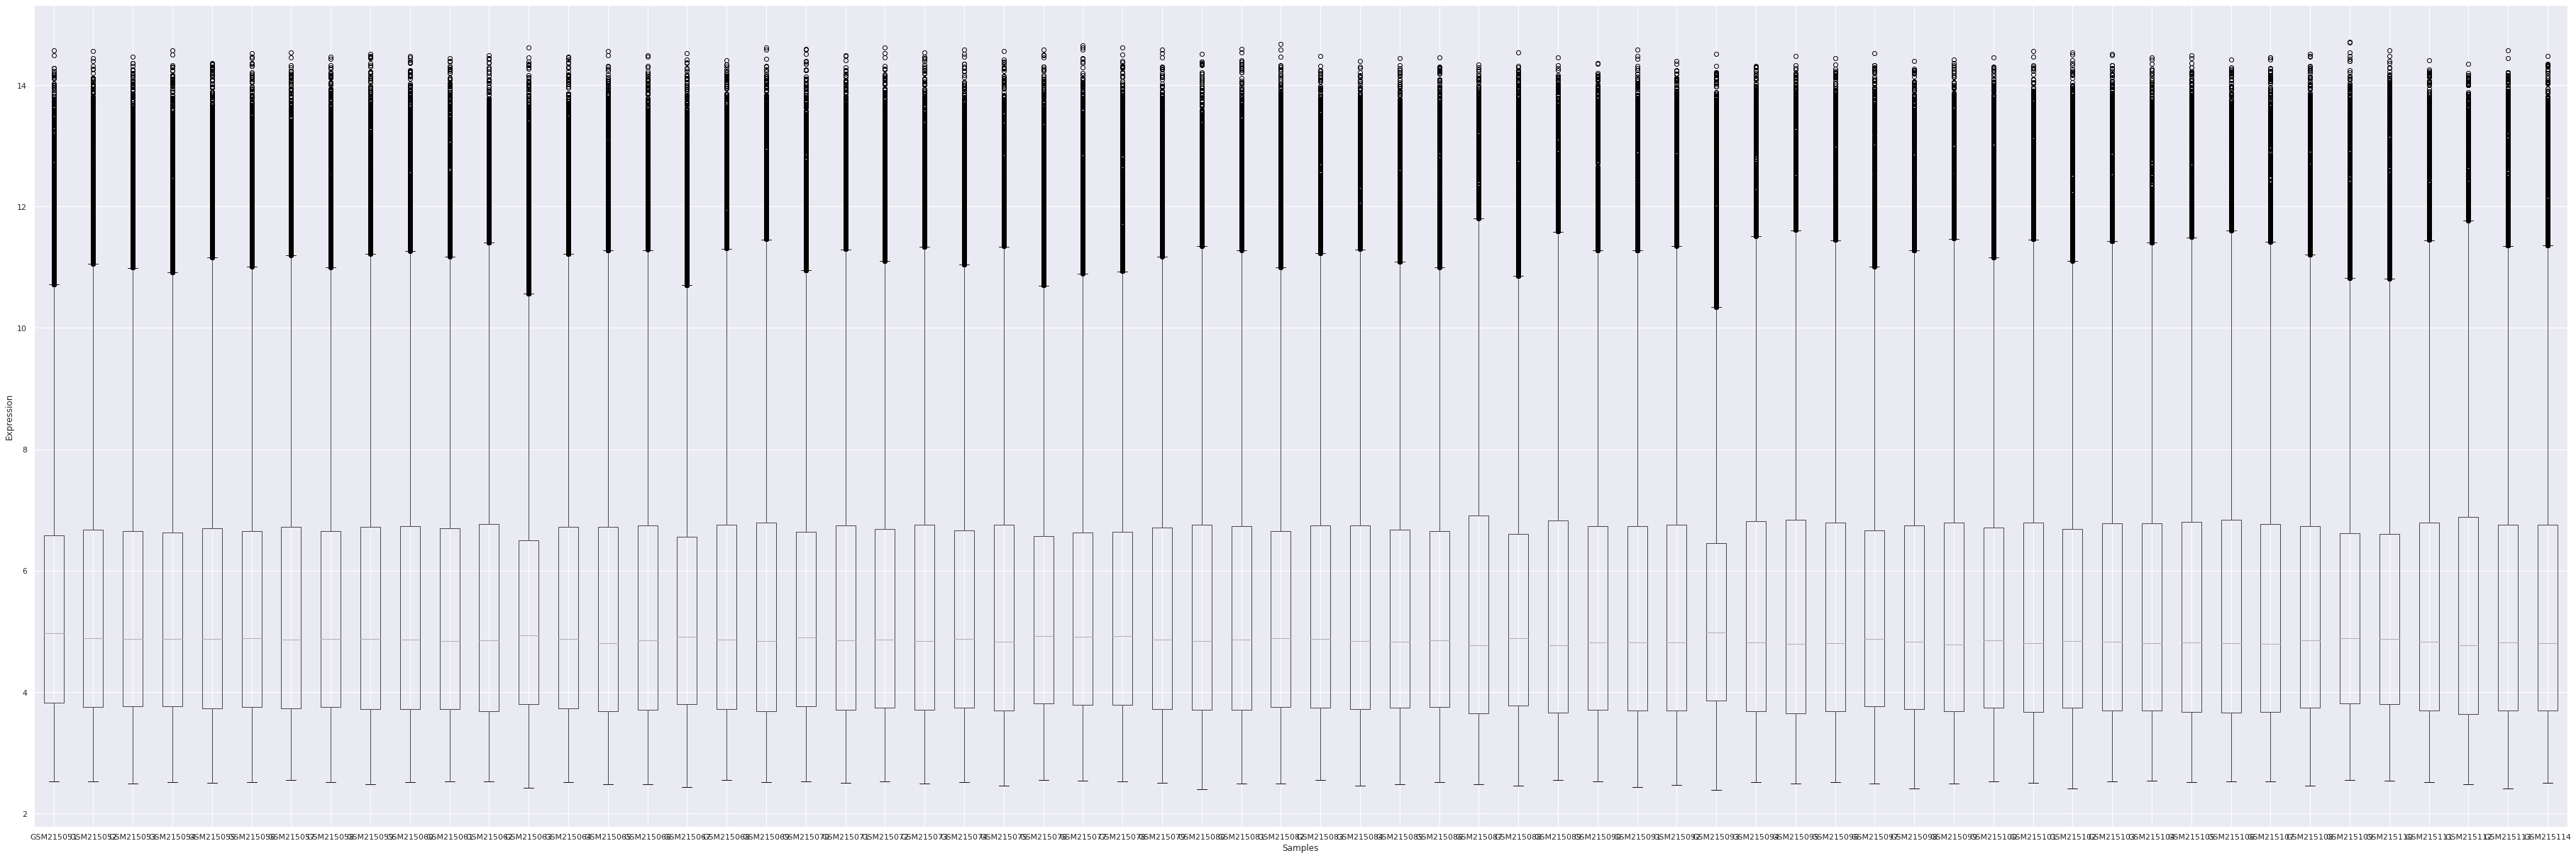

In [5]:
#Get data
df_GSE8671 = xp.get_df(__path__ + 'data/GSE8671_rma_normalized.zip', delimiter=',') #RMA normalized with Alt Analyze
info_GSE8671 = xp.get_info(__path__ + "data/sample_info_gse8671.csv", delimiter=',')
df_GSE8671_c = xp.keep_labels(df_GSE8671, info_GSE8671, label_list=['Normal','Adenoma'])
df_GSE8671_clean = xp.clean_df(df_GSE8671_c)

#Collapse multi-mapping probes
df_GSE8671_collapsed = xp.probe_collapse(df_GSE8671_clean, __path__ + "data/GPL570.zip")
df_GSE8671_collapsed.to_csv(__path__ + "data/collapsed_GSE8671.csv",sep=',')

#Scale dataset
df_GSE8671_scaled, df_GSE8671_labeled = xp.prep_data(df_GSE8671_collapsed, info_GSE8671)

#sort by sample labels
info_GSE8671_sorted = info_GSE8671.copy()
info_GSE8671_sorted = info_GSE8671_sorted.loc[info_GSE8671_sorted[1].isin(['Adenoma', 'Normal'])]
info_GSE8671_sorted = info_GSE8671_sorted.sort_values([1], ascending=False)
info_GSE8671_sorted_list = info_GSE8671_sorted[0].tolist()
df_GSE8671_scaled_sorted = df_GSE8671_scaled[info_GSE8671_sorted_list]

#set palette
gse8671_colors = {'Adenoma': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
        'Normal': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275)}

xp.check_samples(df_GSE8671_clean)

### Read data for GSE20916

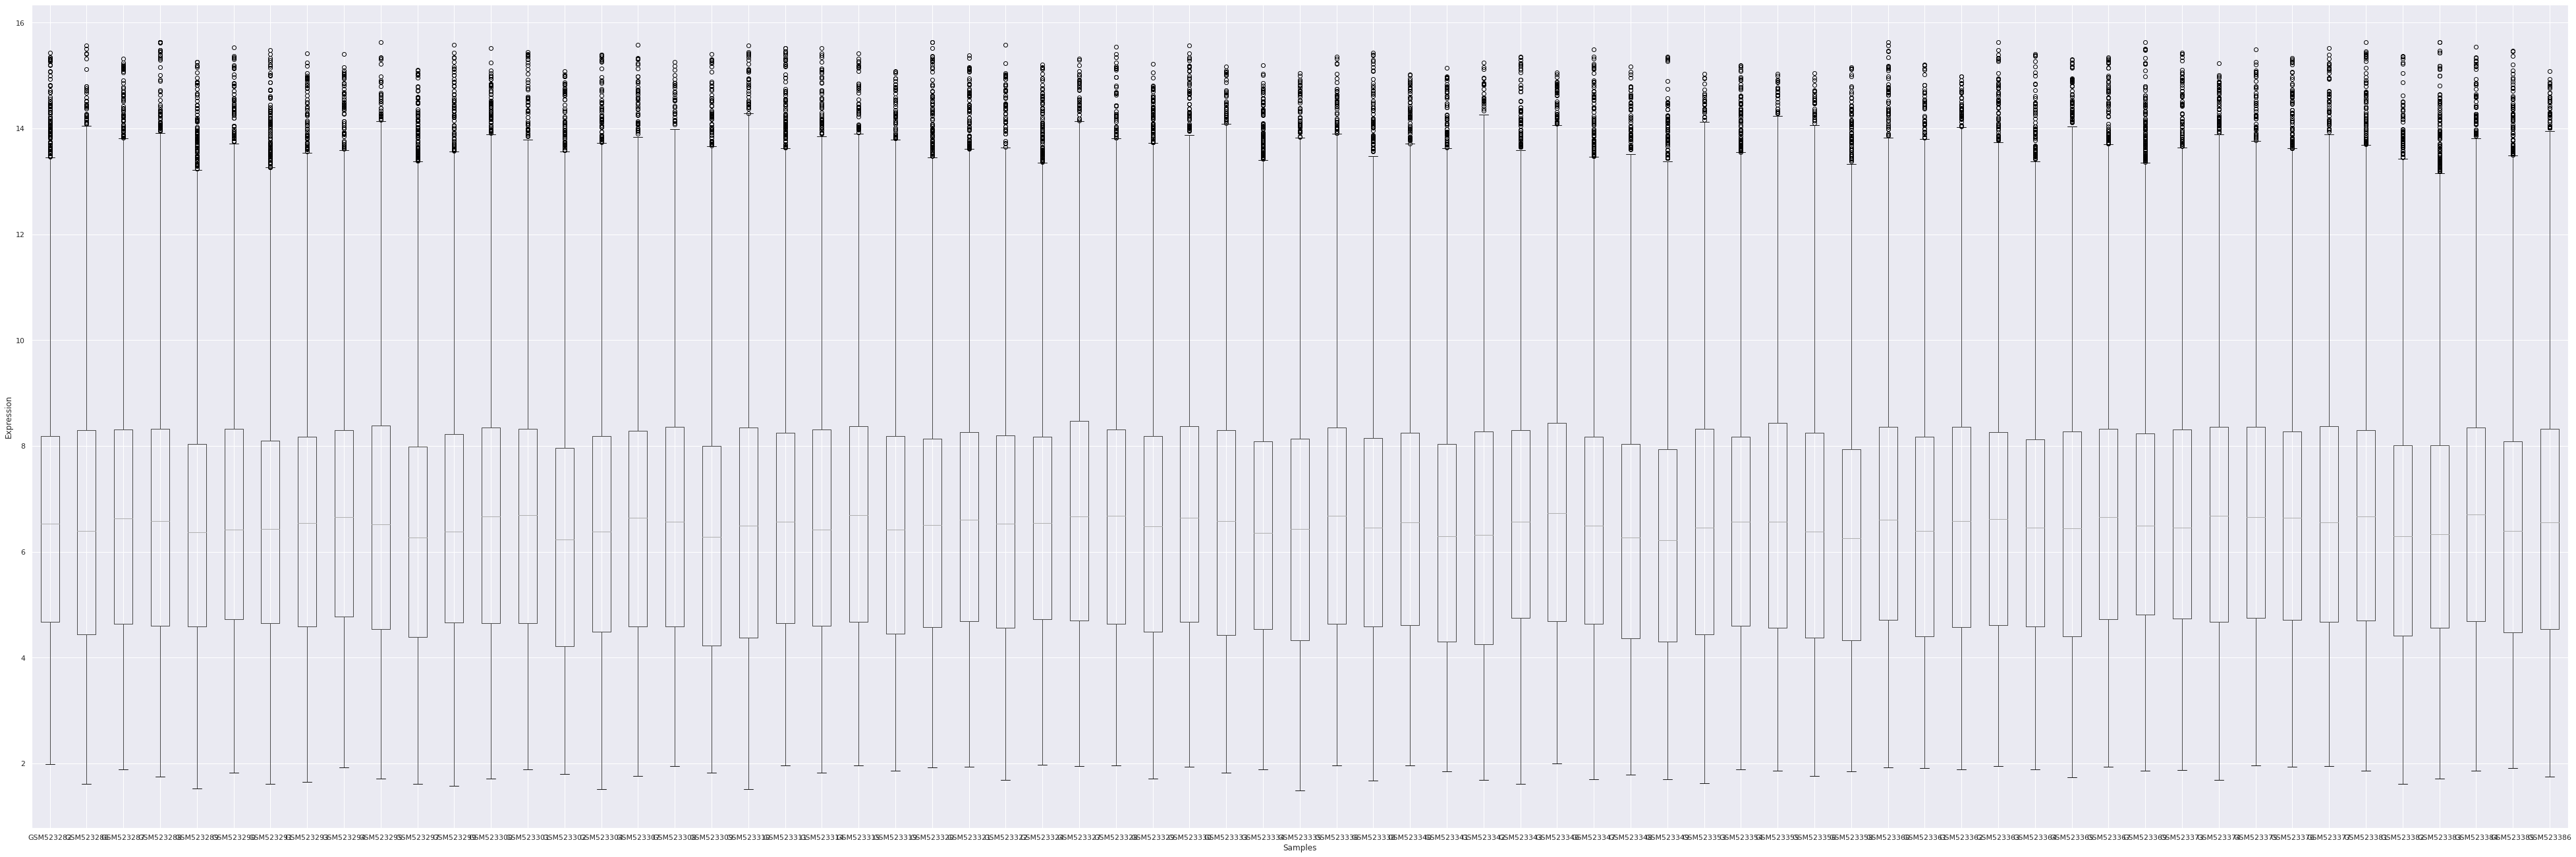

In [6]:
def get_geo(
    geo_id,
    output_info=False, output_path="./"):

    # Get data
    gse = GEOparse.get_GEO(geo=str(geo_id).upper(), destdir=output_path) # Import GSE dataset

    data = gse.pivot_samples('VALUE')
    data = xp.clean_df(data)

    # Get metadata
    # Write data to output file
    if output_info != False:
        with open(str(geo_id).upper() + '.txt', 'w+') as f: # Save all information as text file for reference
            for gsm_name, gsm in gse.gsms.items():
                f.write(gsm_name + '\n')
                for key, value in gsm.metadata.items():
                    f.write(" - %s : %s" % (key, ", ".join(value)) + '\n')

    # Populate metadata with sample ids and names
    metadata = pd.DataFrame(columns=['gsm', 'title']) # Create dataframe
    gsm_list, title_list, data_processing_list = [], [], []
    for gsm_name, gsm in gse.gsms.items():
        for key, value in gsm.metadata.items():
            if key == 'title':
                title_list.append(''.join(value))
            if key == 'geo_accession':
                gsm_list.append(''.join(value))
            if key == 'data_processing':
                data_processing_list.append(''.join(value))

    metadata['gsm'], metadata['title'] = gsm_list, title_list
    metadata.columns = range(metadata.shape[1])

    # Output processing style
    print('Data processing summary:\n' + str(set(data_processing_list))) # To determine if all samples have undergone the sample data processing

    # Clean data
    del data.columns.name
    del data.index.name

    # Clean metadata
    metadata[1] = metadata[1].apply(lambda x: x[0:(re.search("\d", x).start()) - 1])

    return data, metadata

# Get data from GEO database 
#df_GSE20916, info_GSE20916 = get_geo('GSE20916')

#df_GSE20916.to_csv(__path__ + "data/GSE20916_normalized.csv", sep=',')
#info_GSE20916.to_csv(__path__ + "data/sample_info_gse20916.csv", sep=',', index=False)

#Get data
df_GSE20916 = pd.read_csv(__path__ + "data/GSE20916_normalized.zip", index_col=0)
info_GSE20916 = pd.read_csv(__path__ + "data/sample_info_gse20916.csv")
info_GSE20916.columns = [0,1]
info_GSE20916[1] = info_GSE20916[1].str.capitalize() #Make sample types look nice
info_GSE20916 = info_GSE20916.replace('Normal_colon', 'Normal')
df_GSE20916_c = xp.keep_labels(df_GSE20916, info_GSE20916, label_list=['Normal','Adenoma'])
df_GSE20916_clean = xp.clean_df(df_GSE20916_c)

#Collapse multi-mapping probes
df_GSE20916_collapsed = xp.probe_collapse(df_GSE20916_clean, __path__ + "data/GPL570.zip")
df_GSE20916_collapsed.to_csv(__path__ + "data/collapsed_GSE20916.txt",sep='\t')

#Scale sorted dataset
df_GSE20916_scaled, df_GSE20916_labeled = xp.prep_data(df_GSE20916_collapsed, info_GSE20916)

#sort by sample labels
info_GSE20916_sorted = info_GSE20916.copy()
info_GSE20916_sorted = info_GSE20916_sorted.loc[info_GSE20916_sorted[1].isin(['Adenoma','Normal'])]
info_GSE20916_sorted = info_GSE20916_sorted.sort_values([1], ascending=False)
info_GSE20916_sorted_list = info_GSE20916_sorted[0].tolist()
df_GSE20916_scaled_sorted = df_GSE20916_scaled[info_GSE20916_sorted_list]

gse20916_colors = {
        'Adenoma': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
        'Normal': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275)}

xp.check_samples(df_GSE20916_clean)

### Heatmap for GSE8671

<Figure size 432x288 with 0 Axes>

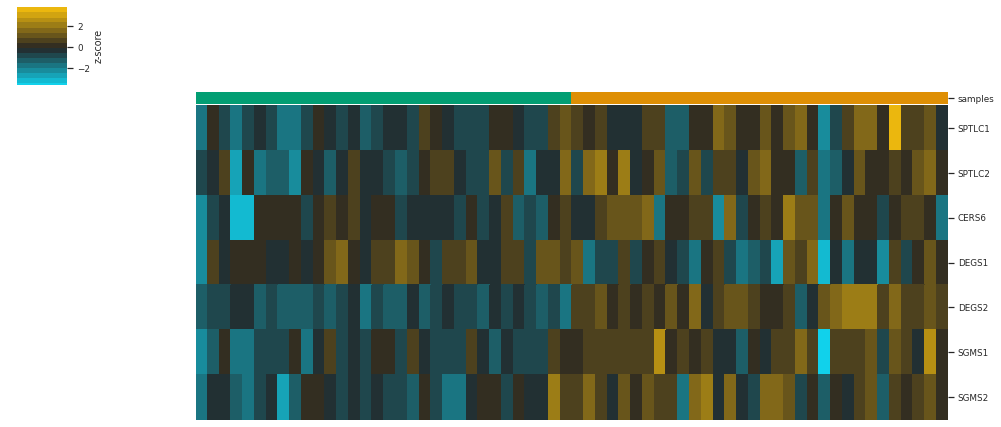

In [7]:
xp.heatmap(
    df_GSE8671_scaled_sorted, 
    info_GSE8671, 
    sample_palette=gse8671_colors, 
    gene_list=test_genes, 
    figsize=(14,6), 
    save_fig=(__path__ + 'plots/GSE8671_heatmap.pdf'),
    row_cluster=False, 
    col_cluster=False, 
    yticklabels=True, 
    xticklabels=False,
    cbar_kws={'label': 'z-score'}, 
    linewidths=0,
    dpi=600)

xp.heatmap(
    df_GSE8671_scaled_sorted, 
    info_GSE8671, 
    sample_palette=gse8671_colors, 
    gene_list=test_genes, 
    figsize=(14,6), 
    save_fig=(__path__ + 'plots/GSE8671_heatmap.png'),
    row_cluster=False, 
    col_cluster=False, 
    yticklabels=True, 
    xticklabels=False,
    cbar_kws={'label': 'z-score'}, 
    linewidths=0,
    dpi=600)

xp.heatmap(
    df_GSE8671_scaled_sorted, 
    info_GSE8671, 
    sample_palette=gse8671_colors, 
    gene_list=test_genes, 
    figsize=(14,6), 
    save_fig=(__path__ + 'plots/GSE8671_heatmap.svg'),
    row_cluster=False, 
    col_cluster=False, 
    yticklabels=True, 
    xticklabels=False,
    cbar_kws={'label': 'z-score'}, 
    linewidths=0,
    dpi=600)

### Effect size for GSE8671

In [8]:
GSE8671_effect = df_GSE8671_collapsed.copy()
GSE8671_effect = GSE8671_effect.loc[test_genes]

GSE8671_normal = []
GSE8671_tumor = []
for i, r in info_GSE8671.iterrows():
    if 'normal' in r[1].lower():
        GSE8671_normal.append(r[0])
    else:
        GSE8671_tumor.append(r[0])
    
GSE8671_data_tumor = GSE8671_effect[GSE8671_tumor]
GSE8671_data_normal = GSE8671_effect[GSE8671_normal]

for gene, row in GSE8671_effect.iterrows():
    comp = GSE8671_data_tumor.loc[gene].values
    base = GSE8671_data_normal.loc[gene].values
    eval_cohens(comp, base)

SPTLC1:	1.09	(Large)
SPTLC2:	0.75	(Medium)
CERS6:	0.65	(Medium)
DEGS1:	-0.76	(Medium)
DEGS2:	2.59	(Huge)
SGMS1:	1.04	(Large)
SGMS2:	1.12	(Large)


### Heatmap for GSE20916

<Figure size 432x288 with 0 Axes>

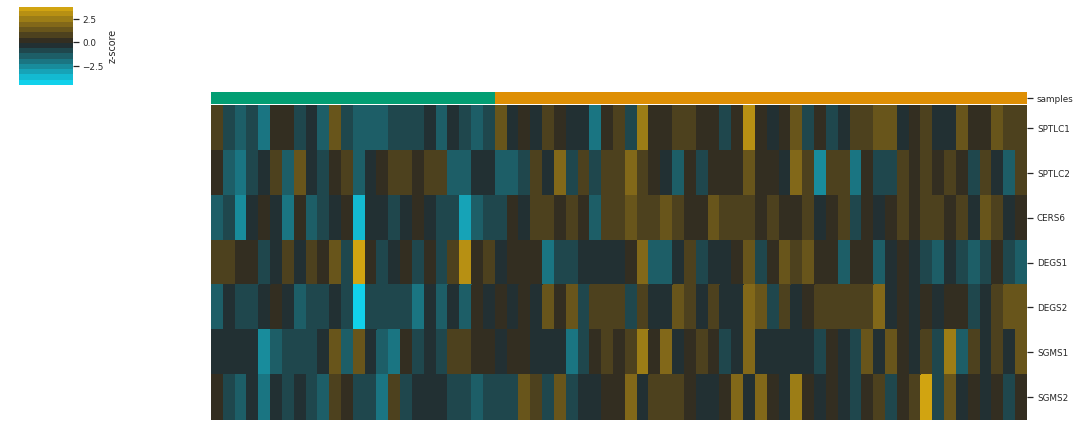

In [9]:
xp.heatmap(
    df_GSE20916_scaled_sorted, 
    info_GSE20916, 
    sample_palette=gse20916_colors, 
    gene_list=test_genes, 
    figsize=(15.1,6), 
    save_fig=(__path__ + 'plots/GSE20916_heatmap.pdf'),
    row_cluster=False, 
    col_cluster=False, 
    yticklabels=True, 
    xticklabels=False,
    cbar_kws={'label': 'z-score'}, 
    linewidths=0,
    dpi=600)

xp.heatmap(
    df_GSE20916_scaled_sorted, 
    info_GSE20916, 
    sample_palette=gse20916_colors, 
    gene_list=test_genes, 
    figsize=(15.1,6), 
    save_fig=(__path__ + 'plots/GSE20916_heatmap.png'),
    row_cluster=False, 
    col_cluster=False, 
    yticklabels=True, 
    xticklabels=False,
    cbar_kws={'label': 'z-score'}, 
    linewidths=0,
    dpi=600)

xp.heatmap(
    df_GSE20916_scaled_sorted, 
    info_GSE20916, 
    sample_palette=gse20916_colors, 
    gene_list=test_genes, 
    figsize=(15.1,6), 
    save_fig=(__path__ + 'plots/GSE20916_heatmap.svg'),
    row_cluster=False, 
    col_cluster=False, 
    yticklabels=True, 
    xticklabels=False,
    cbar_kws={'label': 'z-score'}, 
    linewidths=0,
    dpi=600)

### Effect size for GSE20916

In [10]:
GSE20916_effect = df_GSE20916_collapsed.copy() 
GSE20916_effect = GSE20916_effect.loc[[x for x in test_genes if x != 'PC']] # PC missing from dataset

GSE20916_normal = []
GSE20916_tumor = []
for i, r in info_GSE20916.iterrows():
    if r[0] in df_GSE20916_collapsed.columns.tolist():
        if r[1].lower() == 'normal':
            GSE20916_normal.append(r[0])
        elif r[1].lower() == 'adenoma':
            GSE20916_tumor.append(r[0])
    
GSE20916_data_tumor = GSE20916_effect[GSE20916_tumor]
GSE20916_data_normal = GSE20916_effect[GSE20916_normal]

for gene, row in GSE20916_effect.iterrows():
    comp = GSE20916_data_tumor.loc[gene].values
    base = GSE20916_data_normal.loc[gene].values
    eval_cohens(comp, base)

SPTLC1:	1.37	(Very large)
SPTLC2:	0.24	(Small)
CERS6:	1.62	(Very large)
DEGS1:	-0.6	(Medium)
DEGS2:	1.59	(Very large)
SGMS1:	0.68	(Medium)
SGMS2:	1.06	(Large)
